# Assignment 5 - Reinforcement Learning

## *Zhuangdie Alan Zhou*
Netid:  *zz161*

### Blackjack

Your goal is to develop a reinforcement learning technique to learn the optimal policy for winning at blackjack. Here, we're going to modify the rules from traditional blackjack a bit in a way that corresponds to the game presented in Sutton and Barto's *Reinforcement Learning: An Introduction* (Chapter 5, example 5.1). A full implementation of the game is provided and usage examples are detailed in the class header below.

The rules of this modified version of the game of blackjack are as follows:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  We're playing against a fixed (autonomous) dealer.
- Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and we're refer to it as 'usable' at 11 (indicating that it could be used as a '1' if need be. This game is placed with a deck of cards sampled with replacement.
- The game starts with each (player and dealer) having one face up and one face down card.
- The player can request additional cards (hit, or action '1') until they decide to stop (stay, action '0') or exceed 21 (bust, the game ends and player loses).
- After the player stays, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.



You will accomplish three things:
1. Try your hand at this game of blackjack and see what your human reinforcement learning system is able to achieve
2. Evaluate a simple policy using Monte Carlo policy evaluation
3. Determine an optimal policy using Monte Carlo control

*This problem is adapted from David Silver's [excellent series on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) at University College London*

## 1

### [10 points] Human reinforcement learning 

Using the code detailed below, play 50 hands of blackjack, and record your overall average reward. This will help you get accustomed with how the game works, the data structures involved with representing states, and what strategies are most effective.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
class Blackjack():
    """Simple blackjack environment adapted from OpenAI Gym:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with a deck sampled with replacement.
    
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit = 1) until they decide to stop
    (stay = 0) or exceed 21 (bust).
    
    After the player stays, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    
    http://incompleteideas.net/sutton/book/the-book.html
    
    Usage: 
        Initialize the class:
            game = Blackjack()
        
        Deal the cards:
            game.deal()
            
             (14, 3, False)
             
            This is the agent's observation of the state of the game:
            The first value is the sum of cards in your hand (14 in this case)
            The second is the visible card in the dealer's hand (3 in this case)
            The Boolean is a flag (False in this case) to indicate whether or 
                not you have a usable Ace
            (Note: if you have a usable ace, the sum will treat the ace as a 
                value of '11' - this is the case if this Boolean flag is "true")
            
        Take an action: Hit (1) or stay (0)
        
            Take a hit: game.step(1)
            To Stay:    game.step(0)
            
        The output summarizes the game status:
            
            ((15, 3, False), 0, False)
            
            The first tuple (15, 3, False), is the agent's observation of the
            state of the game as described above.
            The second value (0) indicates the rewards
            The third value (False) indicates whether the game is finished
    """
    
    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = []
        self.player = []
        self.deal()

    def step(self, action):
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stay: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
        return self._get_obs(), reward, done

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def deal(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    #------------------------------------------
    # Other helper functions
    #------------------------------------------
    def cmp(self, a, b):
        return float(a > b) - float(a < b)
    
    def draw_card(self):
        return int(np.random.choice(self.deck))
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def usable_ace(self,hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21
    
    def sum_hand(self,hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)
    
    def is_bust(self,hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self,hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

Here's an example of how it works to get you started:

In [278]:
import numpy as np

# Initialize the class:
game = Blackjack()

# Deal the cards:
s0 = game.deal()
print(s0)

# Take an action: Hit = 1 or stay = 0. Here's a hit:


# If you wanted to stay:
# game.step(2)

# When it's gameover, just redeal:
# game.deal()

(16, 7, True)


In [269]:
s1 = game.step(1)
print(s1)

((12, 10, False), 0, False)


In [270]:
s2 = game.step(1)
print(s2)

((15, 10, False), 0, False)


In [279]:
s3 = game.step(2)
print(s3)

((16, 7, True), -1.0, True)


In [473]:
game.dealer

[8, 9]

In [474]:
game.player

[2, 1, 10]

In [165]:
game._get_obs()

(25, 1, False)

**ANSWER**

In [164]:
reward = [-1,-1,-1,-1,1,1,-1,-1,-1,1,-1,-1,-1,1,-1,1,1,-1,-1,-1,-1,-1,
          -1,-1,-1,1,1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,0,-1,1,-1,1,-1,-1,1]

In [168]:
sum(reward)/len(reward)

-0.38

My overall average reward is -0.38 in 50 plays.

## 2

### [40 points] Perform Monte Carlo Policy Evaluation

Thinking that you want to make your millions playing blackjack, you decide to test out a policy for playing this game. Your idea is an aggressive strategy: always hit unless the total of your cards adds up to 20 or 21, in which case you stay.

**(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Do this for for 10,000 episodes.
2. Repeat (1) for the states without a usable ace.
3. Repeat (1) for the case of 500,000 episodes.
4. Relwat (2) for the case of 500,000 episodes.

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. For both the 10,000 episode case and the 500,000 episode case, record the overall average reward for this policy and report that value. 

**ANSWER**

(a)

In [368]:
def MCBlackjack(episodes):
    '''Calculate the average returns of all possible outcome in Blackjack'''
    dic_usable = dict()
    dic_usable_count = dict()
    dic_unusable = dict()
    dic_unusable_count = dict()
    avg_reward = []
    
    def updatereturn(states):
        '''Update the returns of intermediate steps'''
        all_rewards = 0
        last_rewards = 0
        for s in states[::-1]:
            (player, dealer, usable), value, end = s
            last_rewards += value
            if player <= 21:
                if usable:
                    key = (player, dealer)
                    dic_usable[key] = dic_usable.get(key, 0) + last_rewards
                    dic_usable_count[key] = dic_usable_count.get(key, 0) + 1
                else:
                    key = (player, dealer)
                    dic_unusable[key] = dic_unusable.get(key, 0) + last_rewards
                    dic_unusable_count[key] = dic_unusable_count.get(key, 0) + 1               
            all_rewards += last_rewards
        avg_reward.append(all_rewards/len(states))
        pass
    
    for i in range(episodes):
        states = []
        s0 = game.deal()
        states.append((s0, 0, False))
        
        if np.isin(s0[0], [20, 21]):
            si = game.step(2)
            states.append(si)
            pass
        else:
            si = game.step(1)
            states.append(si)
            
            while si[0][0] < 20 and si[-1] == False:
                si = game.step(1)
                states.append(si)
            if not si[-1]:
                si = game.step(2)
                states.append(si)
        updatereturn(states)
    
    return dic_usable, dic_usable_count, dic_unusable, dic_unusable_count, avg_reward

In [369]:
dic_usable, dic_usable_count, dic_unusable, dic_unusable_count, avg_reward = MCBlackjack(10)

In [513]:
def heatmap_avg_return(episodes, ace):
    '''Heatmap of average return for each state'''
    dic_usable, dic_usable_count, dic_unusable, dic_unusable_count, avg_reward = MCBlackjack(episodes)
    if ace == True:
        result = {k:dic_usable[k]/dic_usable_count[k] for k in dic_usable.keys() & dic_usable_count.keys()}
    else:
        result = {k:dic_unusable[k]/dic_unusable_count[k] for k in dic_unusable.keys() & dic_unusable_count.keys()}
        
    key =np.array([i for i in result.keys()])
    value = np.array([i for i in result.values()]).reshape(-1, 1)
    heatdata = np.hstack((key,value))
    
    heatplotdata = np.zeros((20,10))
    for x in heatdata:
        i = int(x[0])-2
        j = int(x[1])-1
        k = x[2]
        heatplotdata[i, j] = k
        
    plt.imshow(heatplotdata, cmap='RdBu',extent=[1,10,21,2])
    plt.xticks(np.arange(1, 11, step=1))
    plt.yticks(np.arange(21, 1, step= -1))
    plt.ylabel("Players'Sum")
    plt.xlabel("Dealer's Card")
    plt.colorbar()
    if ace == True:
        plt.title('Average Return for Each State with Usable Ace')
    else:
        plt.title('Average Return for Each State without Usable Ace')
    return avg_reward
    

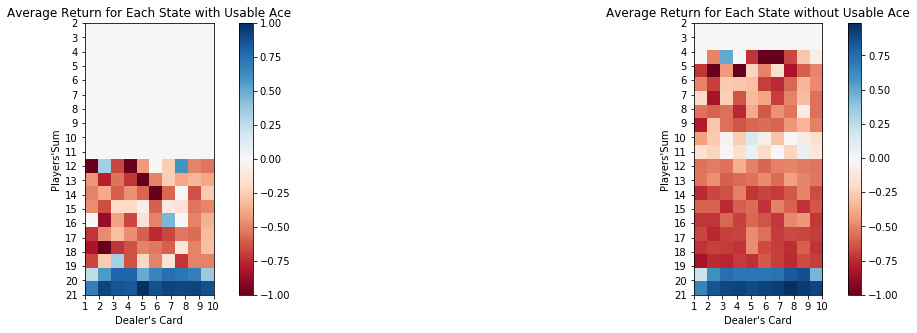

In [514]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
avg10k = heatmap_avg_return(10000, True)
plt.subplot(1,2,2)
avg10k2 = heatmap_avg_return(10000, False)

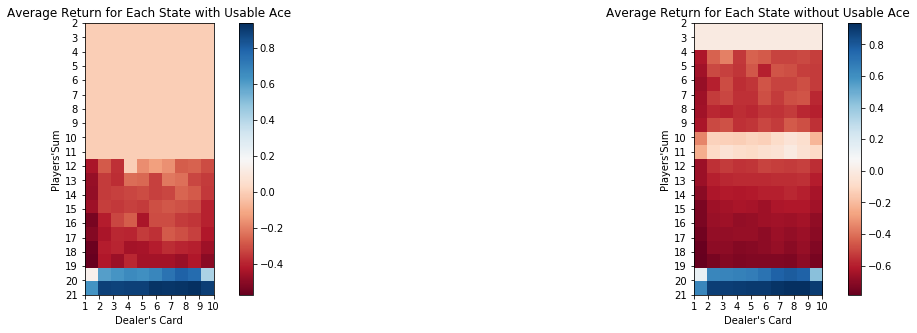

In [515]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
avg5b = heatmap_avg_return(500000, True)
plt.subplot(1,2,2)
avg5b2 = heatmap_avg_return(500000, False)

(b)

In [370]:
def avg_reward_e(avg_reward):
    '''Calculate the cumulative reward'''
    return np.cumsum(avg_reward)/np.arange(1, len(avg_reward)+1)

In [379]:
cum10k_ace = avg_reward_e(avg10k)
cum10k_unace = avg_reward_e(avg5b)

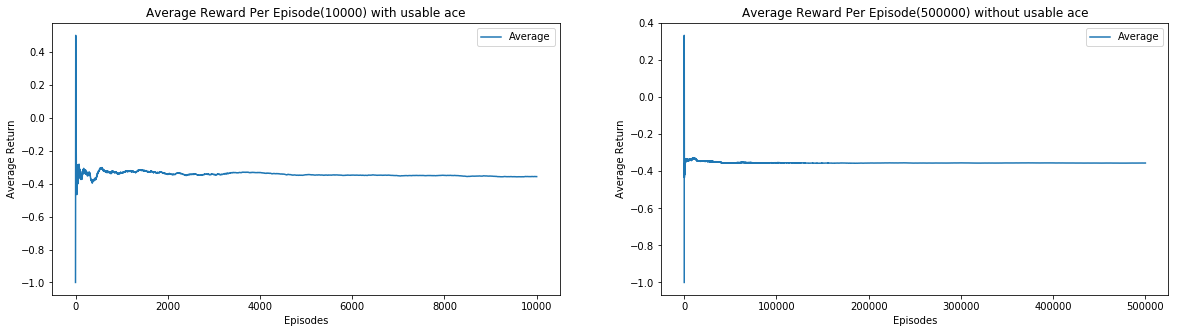

In [526]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.plot(cum10k_ace, label = 'Average')
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.title('Average Reward Per Episode(10000) with usable ace')
plt.legend()

plt.subplot(1,2,2)
plt.plot(cum10k_unace,label = 'Average')
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.title('Average Reward Per Episode(500000) without usable ace')
plt.legend()

plt.show()

The overall average return with usable ace is -0.3575, without usable ace is -0.355576.

## 3

### [40 points] Perform Monte Carlo Control

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the value function and the state value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. $N(s_t,a_t)$ is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed.

Show your result by plotting the optimal value function: $V^*(s) = max_a Q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the new draft edition, or 5.5 in the original edition. Your results SHOULD be very similar to the plots in that text. For these plots include:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the states without a usable ace.
3. A plot of the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot could be an imshow plot with binary values).
4. A plot of the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot could be an imshow plot with binary values).

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. What is the average reward your control strategy was able to achieve?

*Note: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get EXACTLY the optimal policy, but it should be visibly close.* 

**ANSWER**

(a)

In [403]:
import gym
from collections import defaultdict
import sys

In [383]:
env = gym.make('Blackjack-v0')

In [461]:
def get_probs(Q_s, epsilon): 
    policy_s = np.ones(2) * epsilon / 2
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / 2)
    return policy_s
  
def generate_episode_from_Q(env, Q, epsilon):
    episode = []
    state = env.reset()
    allreward = []
    while True:
        action = np.random.choice(np.arange(2), p=get_probs(Q[state], epsilon)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        allreward.append(reward)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    avg = sum(allreward)/len(episode)
    return episode,avg

def update_Q(env, episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [465]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    avgl = []
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        epsilon = max(epsilon*eps_decay, eps_min)
        episode, avg = generate_episode_from_Q(env, Q, epsilon)
        Q = update_Q(env, episode, Q, alpha, gamma)
        avgl.append(avg)
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, avgl

In [468]:
policy, Q, avgl = mc_control(env, 500000, 0.015)

Episode 500000/500000.

In [469]:
V = dict((k,np.max(v)) for k, v in Q.items())

In [510]:
def heatmap_opt_value(V, ace):
    '''Heatmap of average return for each state'''
    heatplotdata = np.zeros((20,10))
    for x in V.keys():
        if x[2] == ace:
            i = x[0]-2
            j = x[1]-1
            k = V[x]
            heatplotdata[i, j] = k
        
    plt.imshow(heatplotdata, cmap='RdBu',extent=[1,10,21,2])
    plt.xticks(np.arange(1, 11, step=1))
    plt.yticks(np.arange(21, 1, step= -1))
    plt.ylabel("Players'Sum")
    plt.xlabel("Dealer's Card")
    plt.colorbar()
    if ace == True:
        plt.title('Average Return for Each State with Usable Ace')
    else:
        plt.title('Average Return for Each State without Usable Ace')
    
    

(a)1

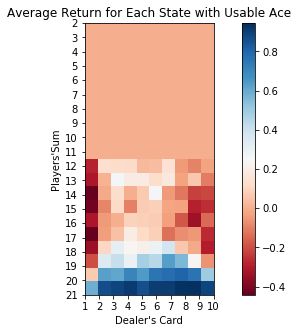

In [511]:
plt.figure(figsize=(10, 5))
heatmap_opt_value(V, True)

(a)2

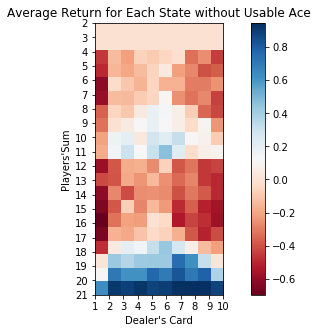

In [512]:
plt.figure(figsize=(10, 5))
heatmap_opt_value(V, False)

a(3)(4)

In [522]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(2, 22)
        y_range = np.arange(10, 0, -1)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z.T, cmap='RdBu', vmin=0, vmax=1, extent=[1, 10, 2, 21])
        plt.xticks(np.arange(1, 11, step=1))
        plt.yticks(np.arange(2, 22, step=1))
        plt.gca().invert_yaxis()
        ax.set_ylabel('Player\'s Sum')
        ax.set_xlabel('Dealer\'s Card')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

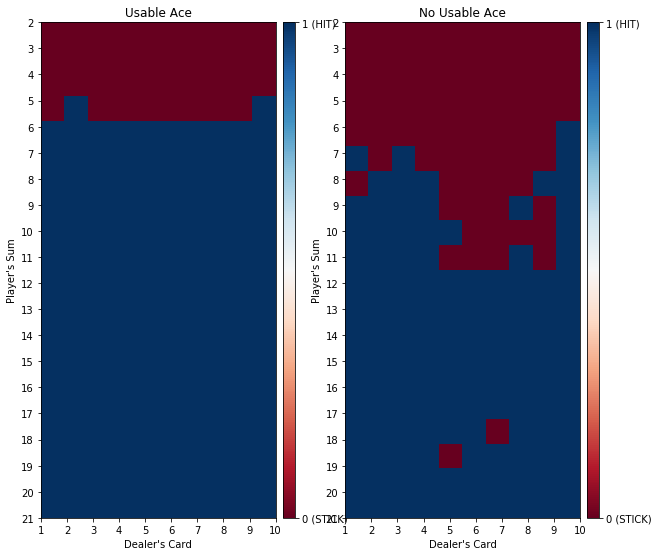

In [523]:
plot_policy(policy)

(b)

In [475]:
cumavg = avg_reward_e(avgl)

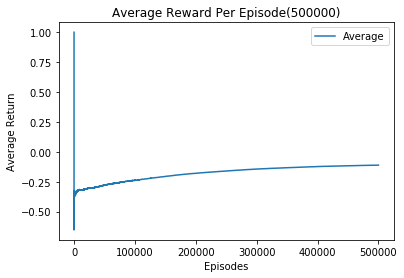

In [478]:
plt.plot(cumavg,label = 'Average')
plt.xlabel('Episodes')
plt.ylabel('Average Return')
plt.title('Average Reward Per Episode(500000)')
plt.legend()

plt.show()

My control reward achieved an average return of -0.11124069.

## 4

### [10 points] Discuss your findings

Compare the performance of your human control policy, the naive policy from question 2, and the optimal control policy in question 3. 
**(a)** Which performs best? Why is this the case? 
**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not?

**ANSWER**

(a)

The optimal control policy performs best, because it is seeking the optimized action in each state. The human control policy attach different actions in different states according to the human, so it totally depends on how well the human is at the game. The naive policy didn't find the optimized action in each state, but attach same action for same state.

(b)

No, we can not have a better policy if we knew the full Markov Decision Process for this environment. All the states and optimized actions are found under the optimal control policy. By taking the expected return of value function and using epsilo-greedy policy to update, we have the best policy already.
